In [4]:
import sklearn
# Debe ser version 1.2.2 de lo contrario ejecutar:
#pip install scikit-learn==1.2.2
print(sklearn.__version__)

1.2.2


# Librerias

In [82]:
import openpyxl
import numpy as np
import time
import os
import pandas as pd
import joblib
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from math import sqrt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import seaborn as sns
import pickle
import pytz

In [3]:
def metrics(y_test, predicciones):

    # Coeficiente de determinación (R-cuadrado)
    r2 = r2_score(y_test, predicciones)
    # Error cuadrado medio
    rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
    # Error Absoluto Medio
    mae = mean_absolute_error(y_test, predicciones)
    # Error Porcentual Absoluto Medio
    # mape = np.mean(np.abs((y_test - predicciones) / y_test)) * 100
    epsilon=1e-10
    mape = np.mean(np.abs((y_test - predicciones) / (y_test + epsilon))) * 100

    print("R^2:", r2)
    print("RMSE", rmse)
    print("MAE:", mae)
    print("MAPE:", mape, "%")

    r2 = round(r2, 6)
    rmse = round(rmse, 6)
    mae = round(mae, 6)
    mape = round(mape, 6)
    return r2, rmse, mae, mape

In [5]:
# Obtener la hora actual en UTC
utc_now = datetime.now(pytz.utc)
mexico_city_tz = pytz.timezone('America/Mexico_City')
mexico_city_now = utc_now.astimezone(mexico_city_tz)
hora_formateada = mexico_city_now.strftime('%Y_%m_%d')
print("Hora actual en Ciudad de México:", hora_formateada)


Hora actual en Ciudad de México: 2025_02_03


# Funciones para el entrenamiento del modelo

In [91]:
def leer_archivo(station, target):

  #file = files[3]
  file_path = os.path.join(dir,station)
  df  = pd.read_csv(file_path)
  df = df.dropna().reset_index(drop=True)
  dates = df.date
  y = df[target]
  #X = df.drop(columns=['date', 'year', 'month', 'day', 'hour', 'minute'])
  X = df.drop(columns=['date', 'year', 'month', 'day', 'minute'])
  corr = X.corr(numeric_only=True)
  plt.figure(figsize=(8,5))
  sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1.0, vmax=1.0)
  plt.title("Correlation Matrix")
  plt.show()
  X = X.drop(columns=[target])
  return X, y, df, file_path, dates


# Convertir los datos en secuencias adecuadas para RNN
def create_sequences(X, y, time_steps, time_future):
    Xs, ys = [], []
    for i in range(len(X) - time_steps-time_future):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps+ time_future])
    return np.array(Xs), np.array(ys)


def create_sequences2(X, y, time_steps, time_future):
  Xs, ys = [], []
  for i in range(len(X) - time_steps-time_future):
    df = X[i:(i + time_steps)]
    array = df.to_numpy()
    # Aplanar el array a un vector
    vector = array.flatten()
    Xs.append(vector)
    ys.append(y[i + time_steps+time_future])
  return np.array(Xs), np.array(ys)


def XGBoost_grid(X,y, station_name, fecha, best_xgb_model_dir, best_xgb_params_dir, time_steps, time_future, results_dir):
  X_seq, y_seq = create_sequences2(X, y, time_steps, time_future)
  # Dividir los datos en conjunto de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
 
  # Definir el modelo XGBoost
  xgb_model = XGBRegressor()

  # Definir los parámetros para GridSearchCV
  param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [3, 4, 5],
      'learning_rate': [0.01, 0.05, 0.1]
  }

  # Inicializar GridSearchCV
  grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2',return_train_score=True)

  # Entrenar GridSearchCV
  grid_search.fit(X_train, y_train)

  results = grid_search.cv_results_
  # Guardar los resultados en un archivo
  with open(results_dir, 'wb') as f:
      pickle.dump(results, f)

  # Obtener los mejores parámetros
  best_params = grid_search.best_params_
  print("Mejores parámetros encontrados:", best_params)

  # Entrenar el modelo final con los mejores parámetros
  best_xgb_model = XGBRegressor(**best_params)
  best_xgb_model.fit(X_train, y_train)

  # Evaluar el modelo en el conjunto de prueba
  rmse = np.sqrt(mean_squared_error(y_test, best_xgb_model.predict(X_test)))
  print("RMSE en conjunto de prueba:", rmse)
  # Guardar el modelo
  
  joblib.dump(best_xgb_model, best_xgb_model_dir)
  joblib.dump(best_params, best_xgb_params_dir)

  loaded_model = joblib.load(best_xgb_model_dir)
  predicciones = loaded_model.predict(X_test)
  r2 = r2_score(y_test, predicciones)
  print("Coeficiente de determinación (R2):", r2)
  [r2, RMSE, MAE, MAPE] = metrics(y_test, predicciones)
  return [r2, RMSE, MAE, MAPE]


## Entrenamos con los datos del tráfico (considerando solo la calle más cercana)

In [18]:
dir = r'C:\Users\valer\Documents\CIC\doctorado\Proyecto_Innovacion\Datos\Train'
files = os.listdir(dir)
print(files)
metric_results_list= []
column_names = ['MODEL', 'TRAFFIC_DATA','TARGET', 'STATION','R2', 'RMSE', 'MAE', 'MAPE', 'LEN_X', 'DATE','TIME_STEPS', 'TIME_FUTURE','HORA']
for station in files:
  if station == 'air_traffic_MER_norm.csv':
    target = "O3"
    X, y, df, file_path, dates = leer_archivo(station, target)
    time_steps = 24
    time_future =1
    X_seq, y_seq = create_sequences2(X, y, time_steps, time_future)
    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    print(station, "X_train",len(X_train), "Y_test",len(y_test))

['air_traffic_MER_norm.csv', 'air_traffic_UIZ_norm.csv']
air_traffic_MER_norm.csv X_train 2797 Y_test 700


In [12]:
X

,CO,NO,NOX,NO2,PM10,PM25,RH,SO2,TMP,WDR,WSP,traffic
0,0.153086,0.006024,0.075529,0.214953,0.312925,0.309524,0.078652,0.031250,0.652174,0.813889,0.318182,0.90
1,0.187654,0.006024,0.111782,0.317757,0.353741,0.416667,0.044944,0.031250,0.739130,0.766667,0.272727,0.78
2,0.138272,0.003012,0.075529,0.224299,0.380952,0.464286,0.022472,0.031250,0.782609,0.108333,0.318182,0.98
3,0.101235,0.000000,0.045317,0.140187,0.319728,0.416667,0.000000,0.015625,0.782609,0.127778,0.303030,0.75
4,0.081481,0.006024,0.030211,0.074766,0.170068,0.202381,0.067416,0.000000,0.695652,0.155556,0.348485,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...
3517,0.177778,0.042169,0.108761,0.205607,0.333333,0.226190,0.505618,0.015625,0.304348,0.988889,0.575758,0.98
3518,0.148148,0.024096,0.078550,0.168224,0.401361,0.154762,0.573034,0.015625,0.217391,0.011111,0.575758,0.95
3519,0.187654,0.045181,0.111782,0.196262,0.292517,0.119048,0.617978,0.015625,0.173913,0.922222,0.378788,0.98
3520,0.162963,0.048193,0.120846,0.224299,0.170068,0.071429,0.640449,0.031250,0.173913,0.822222,0.560606,1.00


In [ ]:
#dir = '/content'
#dir_metrics_result = 'metric_results.csv'
files = os.listdir(dir)
print(files)
metric_results_list= []
column_names = ['MODEL', 'TRAFFIC_DATA','TARGET', 'STATION','R2', 'RMSE', 'MAE', 'MAPE', 'LEN_X', 'DATE','TIME_STEPS', 'TIME_FUTURE','HORA']
for station in files:
  #if station == 'air_traffic_MER_norm.csv':
  if True:
    target = "O3" # Contaminante a predecir
    X, y, df, file_path, dates = leer_archivo(station, target)
    print(file_path)
    station_name = station[12:-9]
    # Obtener la hora actual en UTC
    utc_now = datetime.now(pytz.utc)
    mexico_city_tz = pytz.timezone('America/Mexico_City')
    mexico_city_now = utc_now.astimezone(mexico_city_tz)
    hora_formateada = mexico_city_now.strftime('%Y_%m_%d')
    print("Hora actual en Ciudad de México:", hora_formateada)
    fecha = hora_formateada
    time_steps = 24 #Datos que toma históricos para hacer la predicción
    time_future =24 #Predicción al futuro en horas

    results_dir = 'results_XGB_'+'timesteps_'+str(time_steps)+'_'+target+'_'+str(time_future)+'_'+'_'+station_name +'_'+fecha+'.pkl'
    best_xgb_model_dir = 'best_model_XGBoost_'+str(time_steps)+'timesteps_'+target+'_'+station_name +'_'+fecha+'.pkl'
    best_xgb_params_dir = 'best_paramas_XGBoost_'+str(time_steps)+'timesteps_'+target+'_'+station_name +'_'+fecha+'.pkl'
    [r2, RMSE, MAE, MAPE] = XGBoost_grid(X,y, station, fecha, best_xgb_model_dir, best_xgb_params_dir, time_steps, time_future, results_dir)
    utc_now = datetime.now(pytz.utc)
    mexico_city_tz = pytz.timezone('America/Mexico_City')
    mexico_city_now = utc_now.astimezone(mexico_city_tz)
    hora_formateada = mexico_city_now.strftime('%Y-%m-%d %H:%M')
    metric_results_list = []
    metric_results_list.append(['XGBoost', 'NEAREST_STREET', target,station_name, r2, RMSE, MAE, MAPE, len(X), fecha, time_steps, time_future, hora_formateada])
    metric_results_df = pd.DataFrame(metric_results_list, columns=column_names)
    metric_results_df
    #last_metrics_result = pd.read_csv(dir_metrics_result)
    #all_metrics = pd.concat([last_metrics_result, metric_results_df])
    #all_metrics.to_csv(dir_metrics_result, index=False)

## Prueba de las predicciones, cargando el modelo desde el archivo

In [84]:

def metrics(X, y_test, predicciones, printData):
    n = len(y_test)
    p = X.shape[1]
    # Coeficiente de determinación (R-cuadrado)
    r2 = r2_score(y_test, predicciones)
    # R-cuadrado ajustado
    r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    # Error cuadrado medio
    rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
    # Error Absoluto Medio
    mae = mean_absolute_error(y_test, predicciones)
    
    r2 = round(r2, 6)
    r2_adjusted = round(r2_adjusted, 6)
    rmse = round(rmse, 6)
    mae = round(mae, 6)
    if printData:
      print("R^2:", r2)
      print("R^2 ajustado:", r2_adjusted)
      print("RMSE", rmse)
      print("MAE:", mae)
    return {'r2':r2, 'r2adjusted':r2_adjusted,'rmse': rmse, 'mae':mae}

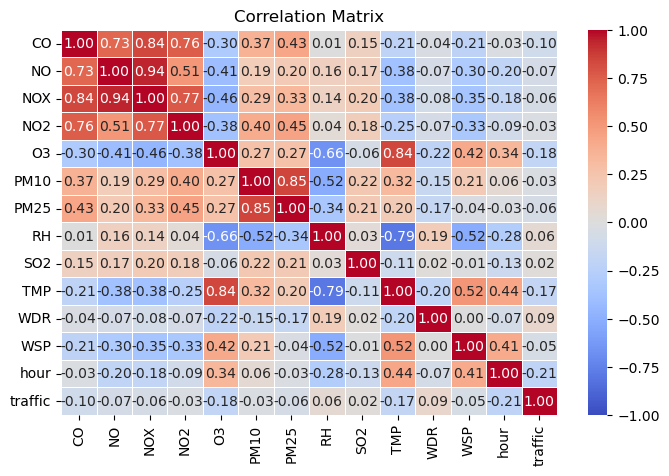

Coeficiente de determinación (R2): 0.8048734602069836


In [92]:
import pickle
import os
model_dir = r'C:\Users\valer\Documents\CIC\doctorado\Proyecto_Innovacion\main\air-poll-predict-dev\ML\Modelos'
model_dir = os.path.join(model_dir,'best_model_XGBoost_24timesteps_O3_1timefuture_UIZ.pkl')

for station in files:
  if station == 'air_traffic_UIZ_norm.csv':
    target = "O3"
    X, y, df, file_path, dates = leer_archivo(station, target)
    break
time_future = 1
X_seq, y_seq = create_sequences2(X, y, time_steps, time_future)
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


xgb_model = XGBRegressor()

# Definir los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2',return_train_score=True)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)
#loaded_model = joblib.load(best_xgb_model_dir)
#loaded_model = joblib.load(model_dir)
#predicciones = loaded_model.predict(X_test)
predicciones = grid_search.predict(X_test)

r2 = r2_score(y_test, predicciones)
print("Coeficiente de determinación (R2):", r2)

#print(predicciones)

In [79]:
scaler_dir =r"C:\Users\valer\Documents\CIC\doctorado\Proyecto_Innovacion\main\air-poll-predict-dev\ML\Scalers\UIZ_scaler.pkl"
with open(scaler_dir, "rb") as f:
    loaded_scaler = pickle.load(f)

min_val = loaded_scaler.data_min_[4]  # Valor mínimo del O3
max_val = loaded_scaler.data_max_[4]  # Valor máximo del O3
predictions = predicciones * (max_val - min_val) + min_val
y_test = y_test * (max_val - min_val) + min_val
metrics_results = metrics(X_test, y_test, predictions, printData=True)

R^2: 0.532536
R^2 ajustado: 0.098248
RMSE 20.600374
MAE: 15.318405


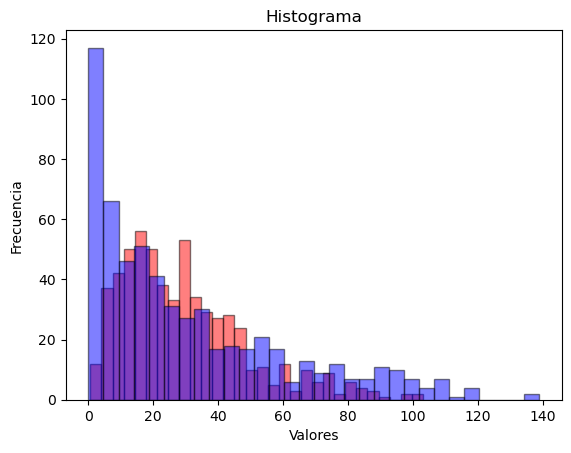

In [81]:
plt.hist(predictions, bins=30, color='red', edgecolor='black', alpha=0.5)
plt.hist(y_test, bins=30, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histograma')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')


plt.show()

In [11]:
def graficar_predicciones(new_hours, target, predicciones, variable):
  """

  Args:
    new_hours:
    target:
    predicciones:
  """
  fechas = new_hours
  # Convertir las fechas a objetos datetime
  fechas_datetime = [datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S') for fecha in fechas]

  # Crear el gráfico
  plt.figure(figsize=(10, 6))

  # Graficar el target y las predicciones en el eje Y
  plt.plot(fechas_datetime, target, label='Target', marker='o')
  plt.plot(fechas_datetime, predicciones, label='Predicciones', marker='o')

  # Configurar formato de fecha en el eje X
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

  # Rotar las fechas para mayor legibilidad
  plt.gcf().autofmt_xdate()

  # Configurar etiquetas y título
  plt.xlabel('Fechas')
  plt.ylabel('Valor')
  title1 = 'Target vs Predicciones a lo largo del tiempo' + variable
  plt.title(title1)

  # Mostrar la leyenda
  plt.legend()
  plt.grid(True)
  # Mostrar el gráfico
  plt.show()

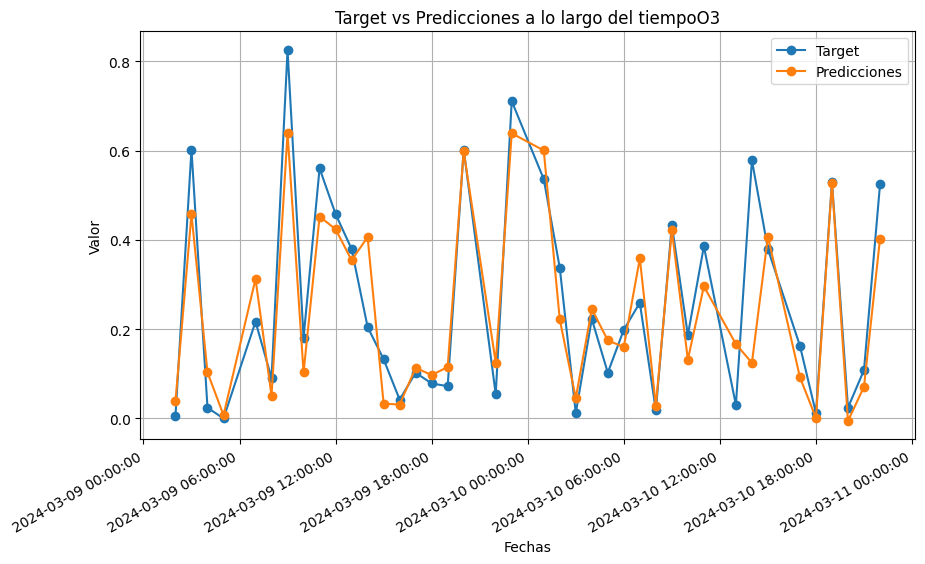

In [12]:
graficar_predicciones(dates[100:140],y_test[100:140], predicciones[100:140], 'O3')